## Nombres premiers

In [1]:
def crible_eratosthene(n):
    """Génère une liste de booléens où True indique qu'un nombre est premier."""

    est_premier = [True] * (n + 1)
    est_premier[0] = est_premier[1] = False  # 0 et 1 ne sont pas premiers

    for i in range(2, int(n**0.5) + 1):
        if est_premier[i]:
            for multiple in range(i * i, n + 1, i):
                est_premier[multiple] = False

    return est_premier

In [2]:
l = crible_eratosthene(100000)

cpt = 0
for i in l[10000:]:
    if i:
        cpt += 1

print(cpt)

8363


In [3]:
l[8363]

True

## Fichier des communes

In [4]:
import pandas as pd

In [5]:
import duckdb

duckdb.sql("""
CREATE OR REPLACE VIEW commune AS
FROM 'https://www.insee.fr/fr/statistiques/fichier/7766585/v_commune_2024.csv';
""")

In [6]:
duckdb.sql("""
SELECT *
  FROM commune
""").to_df()

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
0,COM,01001,84.0,01,01D,012,5,ABERGEMENT CLEMENCIAT,Abergement-Clémenciat,L'Abergement-Clémenciat,0108,None
1,COM,01002,84.0,01,01D,011,5,ABERGEMENT DE VAREY,Abergement-de-Varey,L'Abergement-de-Varey,0101,None
2,COM,01004,84.0,01,01D,011,1,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,None
3,COM,01005,84.0,01,01D,012,1,AMBERIEUX EN DOMBES,Ambérieux-en-Dombes,Ambérieux-en-Dombes,0122,None
4,COM,01006,84.0,01,01D,011,1,AMBLEON,Ambléon,Ambléon,0104,None
...,...,...,...,...,...,...,...,...,...,...,...,...
37539,COM,97613,6.0,976,976D,None,0,M TSANGAMOUJI,M'Tsangamouji,M'Tsangamouji,97613,None
37540,COM,97614,6.0,976,976D,None,1,OUANGANI,Ouangani,Ouangani,97610,None
37541,COM,97615,6.0,976,976D,None,0,PAMANDZI,Pamandzi,Pamandzi,97611,None
37542,COM,97616,6.0,976,976D,None,0,SADA,Sada,Sada,97612,None


In [7]:
duckdb.sql("""
SELECT reg
  FROM commune
 WHERE NCC = 'MAMOUDZOU';
""").to_df()

,REG
0,6


In [8]:
duckdb.sql("""
SELECT COUNT(1)
  FROM commune
 WHERE dep = '973';
""").to_df()

,count(1)
0,22


In [9]:
duckdb.sql("""
SELECT COUNT(1)
  FROM commune
 WHERE dep IN ('02','60','80')
   AND NCC LIKE '%L%L%L%L%';
""").to_df()

,count(1)
0,32


In [10]:
duckdb.sql("""
SELECT dep,
       COUNT(1) AS nb_communes,
       RANK() OVER (ORDER BY COUNT(1) DESC) AS rang
  FROM commune
 WHERE dep IS NOT NULL
 GROUP BY dep
HAVING nb_communes >= 500
 ORDER BY 2 DESC;
""").to_df()

,DEP,nb_communes,rang
0,62,890,1
1,02,798,2
2,80,772,3
3,57,725,4
4,76,708,5
5,21,698,6
6,60,680,7
7,59,648,8
8,51,611,9
9,54,591,10


In [18]:
duckdb.sql("""
SELECT dep
  FROM commune
 WHERE LENGTH(ncc) = (SELECT max(LENGTH(ncc))
                        FROM commune);
""").to_df()

,DEP
0,51


## Polars

In [12]:
import os
import polars as pl

s3_endpoint = f'https://{os.environ["AWS_S3_ENDPOINT"]}'
s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
s3_secret_access_key = os.environ["AWS_SECRET_ACCESS_KEY"]
s3_session_token = os.environ["AWS_SESSION_TOKEN"]
s3_region = os.environ["AWS_DEFAULT_REGION"]

s3_username = os.environ["VAULT_TOP_DIR"] # un peu bancal pour avoir le username

In [13]:
s3_file_path = f"s3://{s3_username}/ENSAI/SQL/tp3-longueur-fil.parquet"

storage_options = {
    "aws_endpoint":  s3_endpoint,
    "aws_access_key_id": s3_access_key,
    "aws_secret_access_key": s3_secret_access_key,
    "aws_token": s3_session_token,
    "aws_region": s3_region
  }

file = pl.scan_parquet(source=s3_file_path, 
                     storage_options=storage_options)

In [14]:
df = file.collect()

In [15]:
print(df)

shape: (50, 2)
┌─────────────────┬──────────┐
│ vetement        ┆ longueur │
│ ---             ┆ ---      │
│ str             ┆ i64      │
╞═════════════════╪══════════╡
│ slip            ┆ 120      │
│ culotte         ┆ 150      │
│ chemise         ┆ 200      │
│ pantalon        ┆ 180      │
│ jupe            ┆ 160      │
│ …               ┆ …        │
│ chemisette      ┆ 130      │
│ cape            ┆ 115      │
│ body            ┆ 145      │
│ veston          ┆ 200      │
│ robe de chambre ┆ 225      │
└─────────────────┴──────────┘


In [16]:
df.filter(pl.col("vetement") == "gilet")

vetement,longueur
str,i64
"""gilet""",170


## Diffusion

In [19]:
file_prenoms = pl.scan_parquet(source="s3://ldeneuville-ensai/diffusion/ENSAI/SQL-TP/prenoms-nat2022.parquet", 
                               storage_options=storage_options)

In [20]:
top10f2021 = file_prenoms\
    .filter((pl.col("sexe") == 2) & 
            (pl.col("annais") == "2021") & 
            (pl.col("preusuel") != "_PRENOMS_RARES"))\
    .group_by("preusuel")\
    .agg(pl.col("nombre").sum().alias("nombre_total"))\
    .sort("nombre_total", descending=True)\
    .limit(10)\
    .collect()

In [21]:
top10f2021

preusuel,nombre_total
str,i64
"""JADE""",3800
"""LOUISE""",3768
"""EMMA""",3201
"""AMBRE""",3017
"""ALICE""",2767
"""ROSE""",2702
"""ANNA""",2514
"""ALBA""",2505
"""ROMY""",2447


In [22]:
top10f2021_sql = file_prenoms\
    .sql("""
      SELECT preusuel, 
             SUM(nombre) AS nombre_total
        FROM self
       WHERE preusuel <> '_PRENOMS_RARES'
         AND annais = '2021'
         AND sexe = 2
       GROUP BY preusuel
       ORDER BY nombre_total DESC
       LIMIT 10
    """)\
    .collect()

top10f2021_sql

preusuel,nombre_total
str,i64
"""JADE""",3800
"""LOUISE""",3768
"""EMMA""",3201
"""AMBRE""",3017
"""ALICE""",2767
"""ROSE""",2702
"""ANNA""",2514
"""ALBA""",2505
"""ROMY""",2447


In [23]:
prenom = "Katia"
annee_debut, annee_fin = 1960, 1980

df_prenom_annee = file_prenoms\
    .filter((pl.col("preusuel") == prenom.upper()) & 
            (pl.col("annais").str.to_integer(strict=False).is_not_null()) &  # Convertir et exclure les nulls
            (pl.col("annais").str.to_integer(strict=False) >= annee_debut) & 
            (pl.col("annais").str.to_integer(strict=False) <= annee_fin))\
    .group_by("annais")\
    .agg(pl.col("nombre").sum().alias("nombre_total"))\
    .sort("annais")\
    .collect()

print(df_prenom_annee)

shape: (21, 2)
┌────────┬──────────────┐
│ annais ┆ nombre_total │
│ ---    ┆ ---          │
│ str    ┆ i64          │
╞════════╪══════════════╡
│ 1960   ┆ 251          │
│ 1961   ┆ 369          │
│ 1962   ┆ 357          │
│ 1963   ┆ 383          │
│ 1964   ┆ 449          │
│ …      ┆ …            │
│ 1976   ┆ 1248         │
│ 1977   ┆ 1101         │
│ 1978   ┆ 925          │
│ 1979   ┆ 882          │
│ 1980   ┆ 730          │
└────────┴──────────────┘


In [24]:
file_prenoms.sql(f"""
SELECT annais, 
       SUM(nombre) AS nombre_total
  FROM self
 WHERE preusuel = 'KATIA'
   AND annais != 'XXXX' 
   AND annais BETWEEN '{annee_debut}' AND '{annee_fin}'
 GROUP BY annais
 ORDER BY annais;
 """).collect()

annais,nombre_total
str,i64
"""1960""",251
"""1961""",369
"""1962""",357
"""1963""",383
"""1964""",449
…,…
"""1976""",1248
"""1977""",1101
"""1978""",925


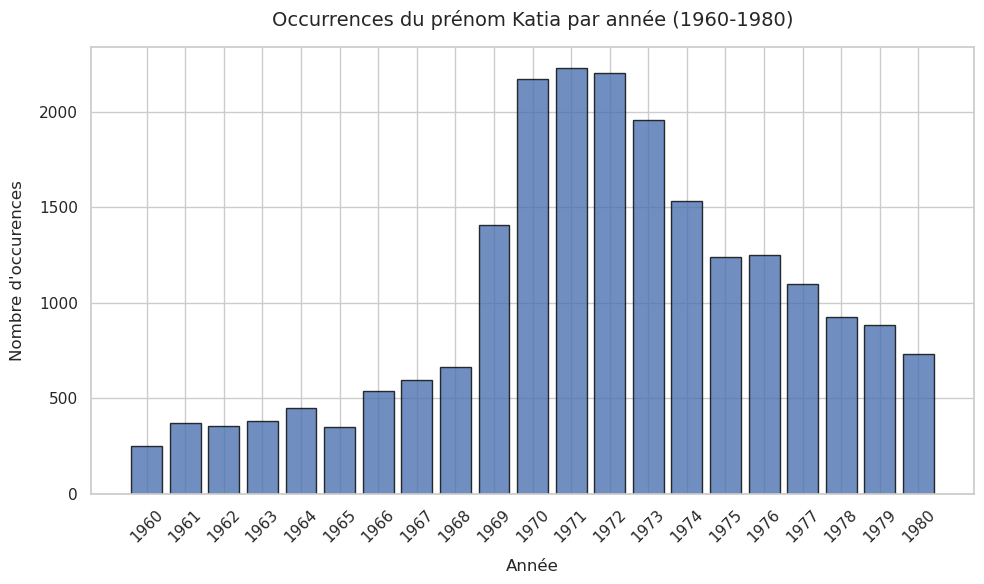

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for a cleaner, more appealing look
sns.set_theme(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Data
years = df_prenom_annee["annais"].to_list()         # Extracts years as a list
counts = df_prenom_annee["nombre_total"].to_list()  # Extracts counts as a list

# Bar plot with custom colors and transparency for better visuals
ax.bar(years, 
       counts, 
       color="#4C72B0", 
       edgecolor="black", 
       alpha=0.8)

# Set labels and title with padding for readability
ax.set_xlabel("Année", fontsize=12, labelpad=10)
ax.set_ylabel("Nombre d'occurences", fontsize=12, labelpad=10)
ax.set_title(f"Occurrences du prénom {prenom} par année ({annee_debut}-{annee_fin})", fontsize=14, pad=15)

# Rotate x-axis labels, improve spacing, and format grid
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()  # Adjust layout for tight fit

# Display the plot
plt.show()

## Le prénom

In [26]:
prenoms_feminins = file_prenoms.sql(f"""
SELECT preusuel, 
       SUM(nombre) AS nombre_total
  FROM self
 WHERE preusuel != '_PRENOMS_RARES'
   AND annais != 'XXXX' 
   AND sexe = 2
   AND annais BETWEEN '1970' AND '2000'
 GROUP BY preusuel
 ORDER BY nombre_total DESC,
          preusuel DESC;
 """).collect()

In [27]:
(8363 - 3) / 5

1672.0

In [28]:
prenoms_feminins.row(1672)

('SERPIL', 271)

In [29]:
prenoms_feminins.with_row_index()[1670:1680]

index,preusuel,nombre_total
u32,str,i64
1670,"""CHAHINEZ""",272
1671,"""XAVIERE""",271
1672,"""SERPIL""",271
1673,"""OUARDIA""",271
1674,"""KLARA""",271
1675,"""ETHEL""",271
1676,"""ALIMA""",271
1677,"""NACIRA""",270
1678,"""MARIE-ANGELIQUE""",269


## Export

In [30]:
import s3fs

fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio-simple.lab.groupe-genes.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])

destination = f"s3://{s3_username}/ENSAI/SQL/output.csv"

with fs.open(destination, mode='wb') as f:
    top10f2021.write_csv(f)

/tmp/ipykernel_2211/2215641480.py:12: UserWarning: Polars found a filename. Ensure you pass a path to the file instead of a python file object when possible for best performance.
  top10f2021.write_csv(f)
